# main.ipynb

\<< Short description >>

Authors: Angelo D. Bonzanini, Giorgos Makrygiorgos, and Victor Miller \\
(c) January 2021

## Requirements:
* Add any particular modules that need to be installed
* Add any files that need to be in the same folder (e.g., ResNet.ipynb)
* Python version
* etc.

\<< Write some basic documentation here >>

## Setting up the environment and importing modules

* First, we import standard libraries such as matplotlib, numpy, etc. If a library (e.g., casadi) is not installed create a new cell and type:
```
!pip install casadi
```

* Because .ipynb files arenot .py files, we cannot readily import them as we would a .py file. Forunately, we can use the [import_ipynb](https://pypi.org/project/import-ipynb/) module to import .ipynb files. We just need to make sure that we change the directory to wherever the .ipynb file is located.

* Note: if you are using Google colab, we need to make sure that we are installing the libraries on our Google drive folder. Otherwise, next time we open the notebook we will have to re-install the libraries. To circumvent this issue, we we first need to give access to the colab notebook to read the Google Drive (using ```drive.mount()```) and then use pip with a target, i.e.,
```
!pip install --target=$path casadi
```


In [1]:
# Import libraries
import os, sys
import matplotlib.pyplot as plt
from casadi import *
import import_ipynb
import numpy as np

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
def plantDynamics(matlabEngine, xAll, z):
    # Define the parameters whose scope is limited to this function
    p1 = 82.3
    p2 = 1.0
    p3 = 0.9
    
    # Convert np arrays to list and then to matlab.double
    xMatlab = matlab.double(xAll.tolist())
    zMatlab = [matlab.double([z[0,0]]), matlab.double([z[0,1]])]
    
    # Call the BCR_Discrete function and convert it to np.array since it is matlab type intially
    xNext = np.array(matlabEngine.BCR_Discrete(xMatlab, zMatlab[0], zMatlab[1], p1, p2, p3))
    
    return xNext

In [4]:
#Load the Wmat file generated after training the neural network initial model
import pickle as pkl
#with open("weights_initialization.npy", 'wb') as f:
fileObject_load = open("weights_initialization.npy", 'rb')
Wmat = pkl.load(fileObject_load)

In [5]:
import scipy.io
model_data = scipy.io.loadmat('Data.mat')
initial_cond_plant =scipy.io.loadmat('init_cond.mat')

## Define a class that intializes all of the parameters and instantiate object

In [6]:
# Note that classes are conventionally defined with a capital first letter
class Parameters:
    # The __init__() function is like a constructor 
    #(can give it arguments if we want to intialize some parameters depending on how we instantiate the class)
    def __init__(self): 

        # Constants (conventionally with all-capitals)
        self.VIN = 1
        self.TSAMP = 1.0
        self.AREA = 0.002436 # reactor cross-sectional area (m^2)
        self.L = 1.06        # reactor length (m)
        self.SELECTIVITY = 0.501
        

        # Neural Net parameters
        self.n_hidden_layers = 3 
        self.n_nodes = 5
        # self.weights
        # self.biases

        # Horizon lengths
        self.Np =  3    # Prediction horizon
        self.Nsim = 40   # Simulation horizon
        self.Nmc = 1      # Monte Carlo simulations (maybe we won't need this)

        # Cost matrices and variable sizes
        self.nx = 3
        self.nu = 2
        # If we had a tracking objective, we would define Q and R here, too 

        # Variable bounds (as a list, not a numpy array)
        self.xMin = [0.0]*self.nx
        self.xMax = [999]*self.nx
        self.uMin = [0.01, 0.1]
        self.uMax = [0.1, 0.9]

        # Initial state vectors (as a list, not a numpy array)
        zInit = model_data.get("Zin")
        xo = initial_cond_plant.get("yo")
        
        self.xInit = zInit[0,-3:].tolist()
        self.zInit = zInit[0,:].tolist()
        self.xAll = xo
        

p = Parameters()

## Modify any functions that need to take CasADi variables as inputs

Here, we redefine the ```predictive_model_resnet(z, W)``` function.


In [7]:
def predictive_model_resnet(zk, Wmat, p): 
    #Assuming you can pass extra arguments to the function for casadi, otherwsise
    #Number of hidden layers and nodes are given once when we get the optimal resnet
    #The Bayesian Optimization Loop will be changing 
    n_hidden_layers = p.n_hidden_layers
    n_nodes = p.n_nodes
    model_input = reshape(zk,1,p.nu+p.nx)
    Wmat_shape = Wmat.shape[0]
    
    #Initialize from input 
    sum0 = mtimes(model_input,Wmat[0]).T #Matrix multiplication weights*inputs
    sumbias0 = sum0 + Wmat[1] #Add bias to construct y = sum(wi*xi) + b
    #neuron_out = swish_eval(sum1bias)
    neuron_out = sumbias0/(1+exp(-sumbias0)) #explicitly writing swish activation, out = fact(y)
    #They are vector quantitites so you might need to change stuff a bit with symbolic vars
#     print(neuron_out.shape)

    #Forward prediction in hidden layers
    for k in range(n_hidden_layers-1):
        sum0 = mtimes(neuron_out.T,Wmat[2*k+2]).T
        sumbias0 = sum0 + Wmat[2*k+3]
        neuron_out = sumbias0/(1+exp(-sumbias0)) #explicitly writing swish activation

    #Final output layer with linear activation
    sum0 = mtimes(neuron_out.T,Wmat[Wmat_shape-2]).T
    sumbias0 = sum0 + Wmat[Wmat_shape-1]
    neuron_out = sumbias0  #linear activation

    return neuron_out.T #+ model_input[0,2:5]

In [8]:
# Define augmented state vector for PDE
xAll = p.xAll

# Define augmented vector of concatenated states and inputs
zk=np.array(p.zInit)
print('zk = ', zk)

# Evaluate neural net prediction 
#xkplusone_neural = DropModel.predict(zk.reshape(1,-1))
#print('x+ from DropModel = ', xkplusone_neural)
xkplusone = predictive_model_resnet(DM(zk),Wmat, p)
print('x+ from predictive_model_resnet = ', xkplusone)

# Evaluate plant model prediction
xkplusonePlant = plantDynamics(eng, xAll, zk.reshape(1,-1))
print('x+ plant = ', xkplusonePlant[0,-3:])

zk =  [0.20933663 0.34245236 0.3        0.04       0.02      ]
x+ from predictive_model_resnet =  [[0.300106, 0.0428471, 0.0147064]]
x+ plant =  [0.32873736 0.04836853 0.02166765]


## Define variables, constraints, and functions

Use classes to organize the code

In [9]:
class CasadiVars:
    def __init__(self, p):
        self.x = MX.sym("x", p.nx)
        self.u = MX.sym("u", p.nu)


class CasadiFunctions:
    def __init__(self, p, v, WeightMat):
        # Placeholder dynamics for double integrator
#         xNext = mtimes(A, v.x) + mtimes(B, v.u)
#         Lstage = mtimes(mtimes((v.x-2).T, p.Q), (v.x-2)) + mtimes(mtimes((v.u).T,p.R), v.u)
        
        # Cost and dynamics for reactor
        xNext = predictive_model_resnet(vertcat(v.u, v.x).T, WeightMat, p).T
        Lstage = -p.AREA * p.L * v.u[0] * v.x[1]
        # Define functions
        self.dynamics = Function('dynamics', [v.u, v.x], [xNext], ['u', 'x'], ['xNext'])
        self.stageCost = Function('stageCost', [v.u, v.x], [Lstage], ['u', 'x'], ['Lstage'])

# class NonlinearConstraints:
#   # Define any additional constraints that cannot be expressed in the form xMin <= x <= xMax (not needed at the moment)
#   def __init__(self, x, p):
      # Use CasADi function syntax



## Define the MPC class, which builds and then solves the OCP

## Define MPC class
This class will build the optimal control problem as well as solve the problem in simulation

In [10]:
class MPC:
    
    class BuildOCP:
        def __init__(self, Parameters, CasadiVars, CasadiFunctions):
            # Start with an empty NLP
            self.w=[]    #Array of all the variables we will be optimizing over
            self.w0 = []
            self.lbw = []
            self.ubw = []
            self.J = 0
            self.g=[]
            self.lbg = []
            self.ubg = []

            # "Lift" initial conditions
            Xk = MX.sym('X0', Parameters.nx)
            self.w += [Xk]
            self.lbw += Parameters.xInit
            self.ubw += Parameters.xInit
            self.w0  += Parameters.xInit

            for i in range(0, Parameters.Np):
                # New NLP variable for the control inputs
                Uk = MX.sym('U_' + str(i), Parameters.nu)
                self.w   += [Uk]
                self.lbw += Parameters.uMin
                self.ubw += Parameters.uMax
                self.w0  += Parameters.uMin

                # Integrate model and calculate stage cost
                xkNext = CasadiFunctions.dynamics(Uk, Xk)
                Zk = reshape(vertcat(Uk, Xk),1,Parameters.nu+Parameters.nx)
                # xkNext = reshape(CasadiFunctions.dropModel(Zk),Parameters.nx,1)
                JNext = CasadiFunctions.stageCost(Uk, Xk)
                self.J = self.J + JNext

                # New NLP variable for states at the next time-step
                Xk = MX.sym('X_' + str(i+1), Parameters.nx)
                self.w   += [Xk]
                self.lbw += Parameters.xMin
                self.ubw += Parameters.xMax
                self.w0  += [0.]*Parameters.nx

                # Equality constraints (model dynamics)
                self.g   += [xkNext-Xk]
                self.lbg += [0]*Parameters.nx
                self.ubg += [0]*Parameters.nx

                # Inequality constraints (selectivity)
                self.g   += [Xk[2]-p.SELECTIVITY*Xk[1]]
                self.lbg += [-inf]
                self.ubg += [0]

            # Terminal cost and constraints (if applicable)
            # N/A

            # Create NLP solver
            self.prob = {'f': self.J, 'x': vertcat(*self.w), 'g': vertcat(*self.g)}
            self.sol_opts = {'ipopt.print_level':0, 'ipopt.max_cpu_time':5}
            self.solver = nlpsol('solver', 'ipopt', self.prob, self.sol_opts)    

            # Store variable dimensions for easy indexing
            self.offsetX0 = 0
            self.offsetU = Parameters.nx
            self.offsetOCP = Parameters.nx + Parameters.nu
    
    
    class SolveMPC:
        def __init__(self, x0, Parameters, CasadiVars, CasadiFunctions, BuildOCP):
            
            xAll = Parameters.xAll
            
            # Predicted variables
            self.xOptPred = np.zeros((Parameters.nx, Parameters.Np+1))
            self.uOptPred = np.zeros((Parameters.nu, Parameters.Np))

            # Real variables
            self.xOptReal = np.zeros((Parameters.nx, Parameters.Nsim+1))
            self.uOptReal = np.zeros((Parameters.nu,Parameters.Nsim))
            self.stageCostReal = np.zeros((Parameters.Nsim,1))
            self.feasibility = []

            # Assign initial conditions
            self.costFnReal = 0;
            self.xOptReal = np.zeros((Parameters.nx,Parameters.Nsim+1))
            self.xOptReal[:,0] = np.array(Parameters.xInit).reshape(Parameters.nx,)
            
            for k in range(0, Parameters.Nsim):

                # Update OCP constraints on initial state
                BuildOCP.lbw[BuildOCP.offsetX0:BuildOCP.offsetX0+Parameters.nx] = x0
                BuildOCP.ubw[BuildOCP.offsetX0:BuildOCP.offsetX0+Parameters.nx] = x0
                BuildOCP.w0[BuildOCP.offsetX0:BuildOCP.offsetX0+Parameters.nx] = x0

                # Solve the NLP
                sol = BuildOCP.solver(x0=BuildOCP.w0, lbx=BuildOCP.lbw, ubx=BuildOCP.ubw, lbg=BuildOCP.lbg, ubg=BuildOCP.ubg)
                w_opt = sol['x'].full().flatten()
                J_opt = sol['f'].full().flatten()

                # Extract first optimal input
                uOpt = w_opt[BuildOCP.offsetU:BuildOCP.offsetOCP]
                # Calculate the real optimal cost
                self.stageCostReal[k] = CasadiFunctions.stageCost(uOpt, x0);

                # Plant model
                zReal = np.concatenate((uOpt, x0))
                xAll = plantDynamics(eng, xAll, zReal.reshape(1,-1))
                x0 = xAll[0,-3:]+0*np.random.normal(0, 0.1, size=(Parameters.nx, 1)).reshape(Parameters.nx,)

                # Save the trajectory
                self.uOptReal[:,k] = uOpt
                self.xOptReal[:,k+1] = x0.reshape(Parameters.nx,)


                # Determine Feasibility
                if(BuildOCP.solver.stats()['return_status']=='Infeasible_Problem_Detected'):
                    self.feasibility+=[0]
                elif(BuildOCP.solver.stats()['return_status']=='Solve_Succeeded'):
                    self.feasibility+=[1]
                else:
                    self.feasibility+=[2]    

                print('--------------------------------------------')
                print("Iteration %i of %i" %(k+1, Parameters.Nsim))
                print('uOpt = ', uOpt)
                print(BuildOCP.solver.stats()['return_status'])
                print('--------------------------------------------')
            

     

## Closed-loop Simulation

In [12]:
# Instantiate objects
v = CasadiVars(p)
fn = CasadiFunctions(p, v, Wmat)
mpc = MPC

# Build the optimal control problem
ocp = mpc.BuildOCP(p, v, fn)

# Define the initial condition
x0 = p.xAll[0,-3:]

# Solve the MPC
mpcSol = mpc.SolveMPC(x0, p, v, fn, ocp)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  40.00us (  2.50us)  41.00us (  2.56us)        16
       nlp_g  | 123.00us (  7.69us) 127.00us (  7.94us)        16
  nlp_grad_f  | 676.00us ( 48.29us)   1.64ms (117.36us)        14
  nlp_hess_l  | 714.00us ( 59.50us) 721.00us ( 60.08us)        12
   nlp_jac_g  | 541.00us ( 38.64us) 651.00us ( 46.50us)        14
       total  |   9.64ms (  9.64ms)  11.39ms ( 11.39ms)         1
--------------------------------------------
Iteration 1 of 40
uOpt =  [0.09997633 0.36130318]
Solve_Succeeded
---------------------------------------

--------------------------------------------
Iteration 14 of 40
uOpt =  [0.09999424 0.67466846]
Solve_Succeeded
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  56.00us (  3.50us)  55.00us (  3.44us)        16
       nlp_g  | 186.00us ( 11.62us) 188.00us ( 11.75us)        16
  nlp_grad_f  | 124.00us (  7.29us) 122.00us (  7.18us)        17
  nlp_hess_l  |   1.15ms ( 76.33us)   1.16ms ( 77.20us)        15
   nlp_jac_g  | 693.00us ( 40.76us) 703.00us ( 41.35us)        17
       total  |  11.28ms ( 11.28ms)  11.43ms ( 11.43ms)         1
--------------------------------------------
Iteration 15 of 40
uOpt =  [0.09999428 0.67577484]
Solve_Succeeded
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  57.00us (  3.56us)  54.00us (  3.38us)        16
       nlp_g  | 195.00us ( 12.19us) 198.00us ( 12.38us)        16
  nlp_grad_f  | 123.00us (

--------------------------------------------
Iteration 32 of 40
uOpt =  [0.09999396 0.647662  ]
Solve_Succeeded
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  28.00us (  2.00us)  30.00us (  2.14us)        14
       nlp_g  | 100.00us (  7.14us) 100.00us (  7.14us)        14
  nlp_grad_f  |  76.00us (  5.07us)  76.00us (  5.07us)        15
  nlp_hess_l  | 711.00us ( 54.69us) 715.00us ( 55.00us)        13
   nlp_jac_g  | 425.00us ( 28.33us) 426.00us ( 28.40us)        15
       total  |   6.95ms (  6.95ms)   6.94ms (  6.94ms)         1
--------------------------------------------
Iteration 33 of 40
uOpt =  [0.09999395 0.64648702]
Solve_Succeeded
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  32.00us (  2.29us)  35.00us (  2.50us)        14
       nlp_g  |  98.00us (  7.00us) 104.00us (  7.43us)        14
  nlp_grad_f  |  76.00us (

## Plot Trajectories

<IPython.core.display.Javascript object>


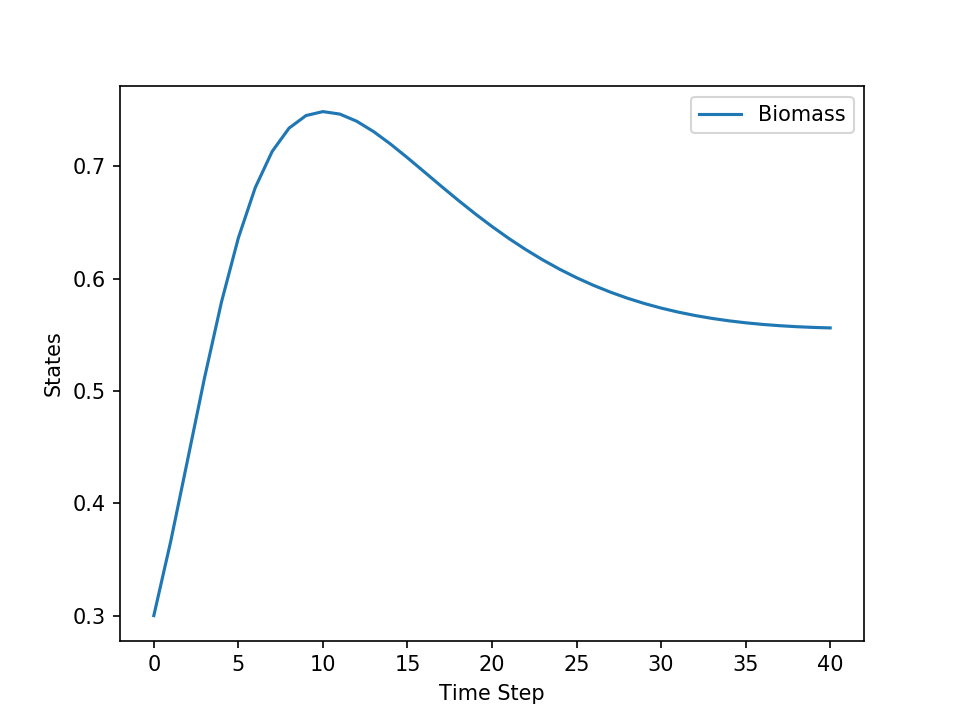

<IPython.core.display.Javascript object>


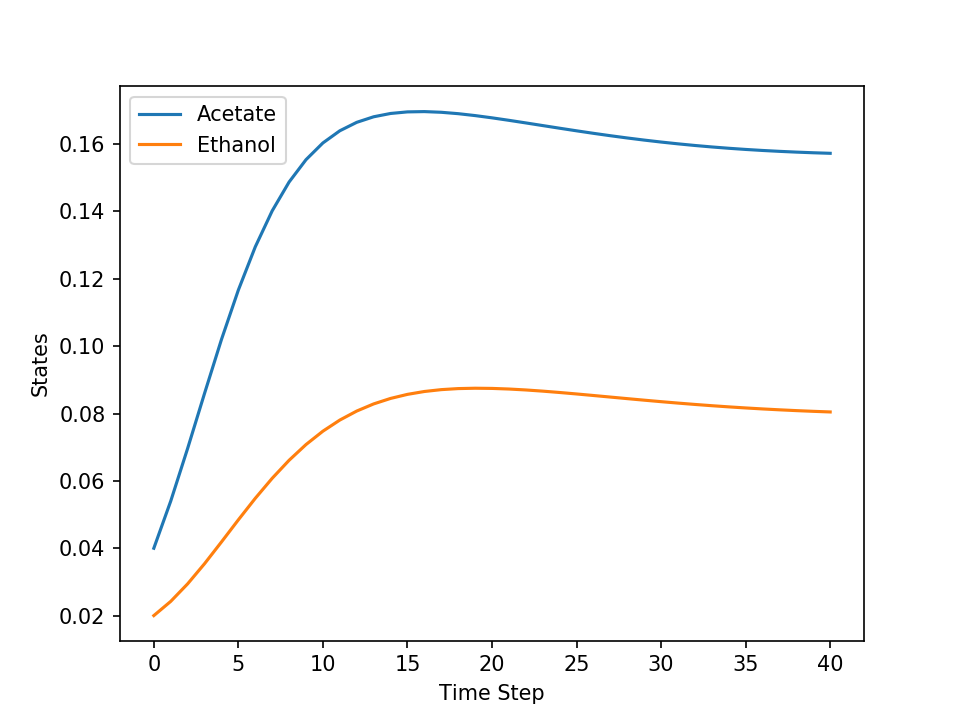

<IPython.core.display.Javascript object>


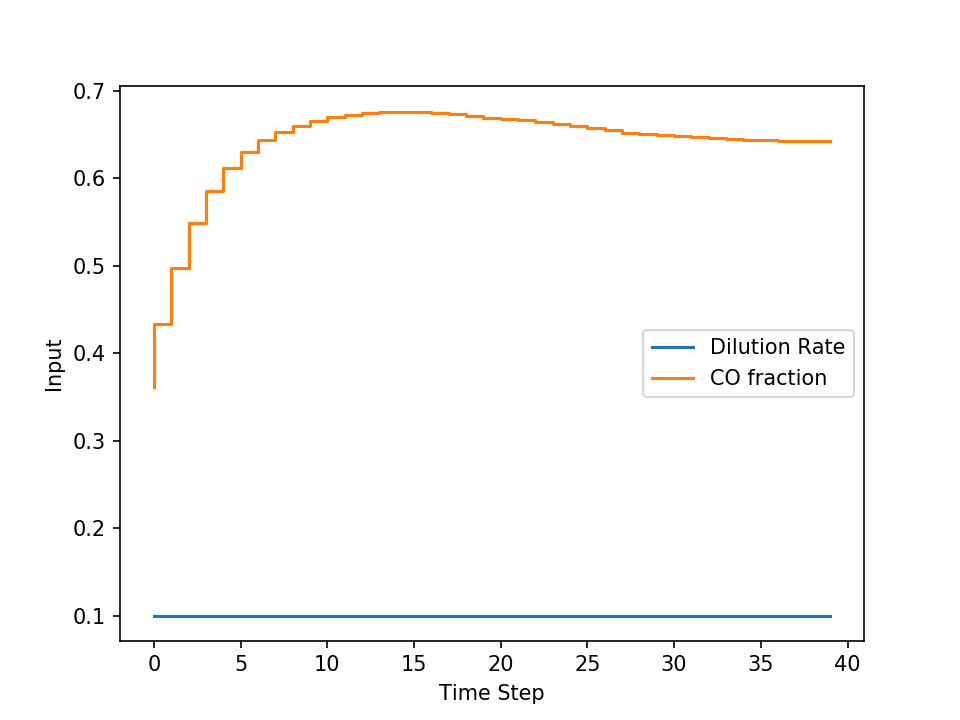

<IPython.core.display.Javascript object>

In [13]:
%matplotlib notebook
dpiVal = 75

plt.figure(dpi=dpiVal)
plt.plot(mpcSol.xOptReal[0,:],label='Biomass')
plt.xlabel('Time Step')
plt.ylabel('States')
plt.legend()
plt.show()

plt.figure(dpi=dpiVal)
plt.plot(mpcSol.xOptReal[1,:],label='Acetate')
plt.plot(mpcSol.xOptReal[2,:],label='Ethanol')
plt.xlabel('Time Step')
plt.ylabel('States')
plt.legend()
plt.show()

plt.figure(dpi=dpiVal)
plt.step(range(0,p.Nsim), mpcSol.uOptReal[0,:],label='Dilution Rate')
plt.step(range(0,p.Nsim), mpcSol.uOptReal[1,:],label='CO fraction')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Input')
plt.show()


plt.figure(dpi=dpiVal)
plt.step(mpcSol.feasibility, 'r.',label='0: Infeasible\n1: Feasible\n2: Other')
plt.legend()
plt.ylim(-0.1, 2.1)
plt.xlabel('Time Step')
plt.ylabel('Feasibility')
plt.show()

# Draft code below here

<IPython.core.display.Javascript object>


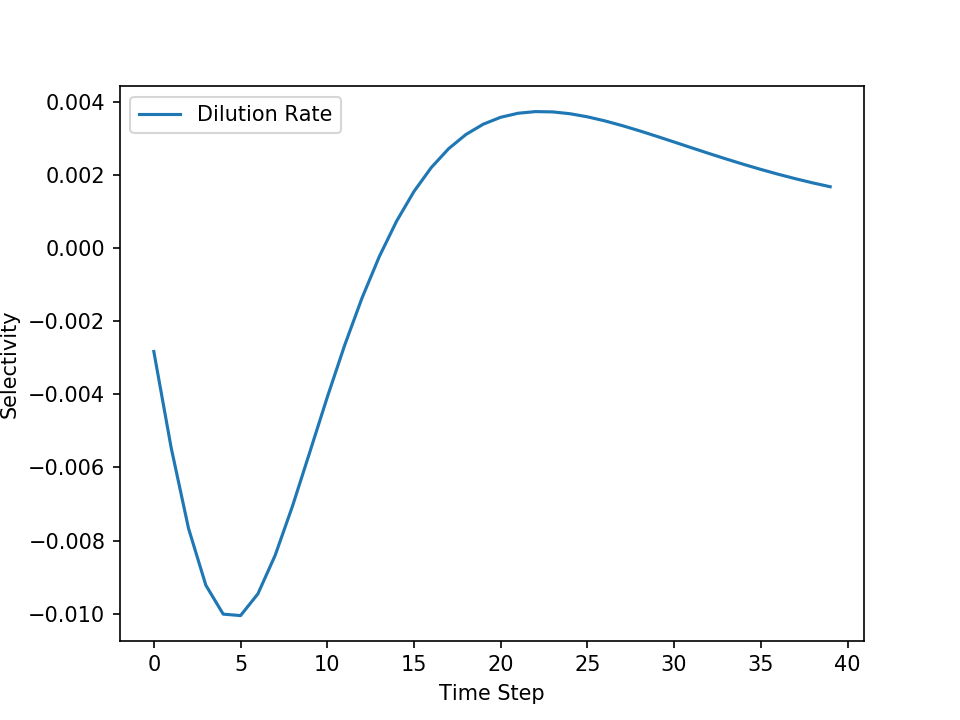

In [15]:
plt.figure(dpi=dpiVal)
plt.plot(range(0,p.Nsim), mpcSol.xOptReal[2,1:]-p.SELECTIVITY*mpcSol.xOptReal[1,1:],label='Dilution Rate') #Should be from -inf to 0
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Selectivity')
plt.show()

Here is the total amount of acetate mols

In [17]:
#Total number of mols produced 
nAcTot = -sum(mpcSol.stageCostReal)
print(nAcTot)

Wmat.shape #This is shape 8  (3 hidden layers+1 output layer)
print(Wmat[6],Wmat[7])

[0.00153561]
[[ 0.5650164   1.1574372   0.00895347]
 [-0.7857537   0.29824823  0.3813304 ]
 [-0.24570245 -0.6406025  -0.40119645]
 [ 0.955142   -0.14983416  0.9790309 ]
 [ 0.93934315  0.06355438 -0.7085682 ]] [0.16367456 0.03101907 0.01859069]


Now to change some of the parameters

In [18]:
Wmat[7] = np.array([0.3,0.01,0.05],dtype=float) 

In [19]:
Wmat[7][0]

0.3

In [20]:
Wmat[6][0][0] = 0.03
Wmat[6][1][0] = 0.03
Wmat[6][2][0] = 0.03
Wmat[6][3][0] = 0.03
Wmat[6][4][0] = 0.03

In [21]:
Wmat[6]

array([[ 0.03      ,  1.1574372 ,  0.00895347],
       [ 0.03      ,  0.29824823,  0.3813304 ],
       [ 0.03      , -0.6406025 , -0.40119645],
       [ 0.03      , -0.14983416,  0.9790309 ],
       [ 0.03      ,  0.06355438, -0.7085682 ]], dtype=float32)

First import skopt which has the BO tools

In [22]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer 

Here we define the optimization arguments. For a given matrix Wmat (assuming that it's 3 layers 5 nodes) 
we want to tweak some weights and biases. The weights and biases are your decision vars for BO

In [23]:
dim_weight00 = Real(low= -1.5*Wmat[6][0][0], high=1.5*Wmat[6][0][0], prior='log-uniform',
                         name='weight00')
dim_weight10 = Real(low= -1.5*Wmat[6][1][0], high=1.5*Wmat[6][1][0], prior='log-uniform',
                         name='weight10')
dim_weight20 = Real(low= -1.5*Wmat[6][2][0], high=1.5*Wmat[6][2][0], prior='log-uniform',
                         name='weight20')
dim_weight30 = Real(low= -1.5*Wmat[6][3][0], high=1.5*Wmat[6][3][0], prior='log-uniform',
                         name='weight30')
dim_weight40 = Real(low= -1.5*Wmat[6][4][0], high=1.5*Wmat[6][4][0], prior='log-uniform',
                         name='weight40')


dim_bias0 = Real(low= -1.5*Wmat[7][0], high=1.5*Wmat[7][0], prior='log-uniform',
                         name='bias0')
dim_bias1 = Real(low= -1.5*Wmat[7][1], high=1.5*Wmat[7][1], prior='log-uniform',
                         name='bias1')
dim_bias2 = Real(low= -1.5*Wmat[7][2], high=1.5*Wmat[7][2], prior='log-uniform',
                         name='bias2')


dimensions = [dim_weight00,
              dim_weight10,
              dim_weight20,
              dim_weight30,
              dim_weight40,
              dim_bias0,
              dim_bias1,
              dim_bias2
]
default_parameters = [Wmat[6][0][0], Wmat[6][1][0], Wmat[6][2][0],Wmat[6][3][0], Wmat[6][4][0], Wmat[7][0],
                     Wmat[7][1],Wmat[7][2]]

/Users/adbonzanini/opt/anaconda3/lib/python3.7/site-packages/skopt/space/space.py:318: RuntimeWarning: invalid value encountered in log10
  np.log10(self.low) / self.log_base,
/Users/adbonzanini/opt/anaconda3/lib/python3.7/site-packages/skopt/space/space.py:320: RuntimeWarning: invalid value encountered in log10
  np.log10(self.low) / self.log_base)


Now we define the obj function for BO. \
Inputs: some weights and biases\
Output: closed loop cost, i.e., total number of mols produced

In [33]:
@use_named_args(dimensions=dimensions)
def objective(weight00,weight10,weight20,weight30,weight40,bias0,bias1,bias2):
    
    #Gives new values to Wmat
    
    #Load the Wmat file generated after training the neural network initial model
    fileObject_load = open("weights_initialization.npy", 'rb')
    Wmat = pkl.load(fileObject_load)
    
    Wmat[6][0][0] = weight00
    Wmat[6][1][0] = weight10
    Wmat[6][2][0] = weight20
    Wmat[6][3][0] = weight30
    Wmat[6][4][0] = weight40

    Wmat[7][0]=bias0
    Wmat[7][1]=bias1
    Wmat[7][2]=bias2
    
    
    
    #Here solve the MPC problem
    #Given the tweaked Wmat and same constraints, stage cost etc.. 
    fn = CasadiFunctions(p, v, Wmat)
    mpc = MPC
    # Build the optimal control problem with the new dynamics based on the new Wmat 
    ocp = mpc.BuildOCP(p, v, fn)
    # Define the initial condition
    x0 = p.xAll[0,-3:]
    # Solve the MPC
    mpcSol = mpc.SolveMPC(x0, p, v, fn, ocp)

    return np.float(-sum(mpcSol.stageCostReal)) #This is a maximization problem so need a negative sign

Run this cell to perform the BO

In [34]:
gp_result = gp_minimize(func=objective,
                            dimensions=dimensions,
                            n_calls=11,
                            noise= 1e-8,
                            n_jobs=-1,
                            acq_func="EI",
                            x0=default_parameters)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 119.00us (  3.05us) 120.00us (  3.08us)        39
       nlp_g  | 479.00us ( 12.28us) 487.00us ( 12.49us)        39
  nlp_grad_f  |  93.00us (  5.81us)  89.00us (  5.56us)        16
  nlp_hess_l  |   1.61ms ( 73.27us)   1.67ms ( 76.09us)        22
   nlp_jac_g  |   1.19ms ( 39.63us)   1.27ms ( 42.33us)        30
       total  |  21.88ms ( 21.88ms)  22.19ms ( 22.19ms)         1
--------------------------------------------
Iteration 1 of 40
uOpt =  [0.1 0.1]
Infeasible_Problem_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  85.00us (  2.18us)  82.00us (  2.10us)        39
       nlp_g  | 290.00us (  7.44us) 290.00us (  7.44us)        39
  nlp_grad_f  |  82.00us (  5.12us)  84.00us (  5.25us)        16
  nlp_hess_l  |   1.28ms ( 58.18us)   1.31ms ( 59.41us)        22
   nlp_jac_g  | 933.00us ( 31.10us) 956.00us ( 31.87us

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 109.00us (  2.79us) 102.00us (  2.62us)        39
       nlp_g  | 390.00us ( 10.00us) 396.00us ( 10.15us)        39
  nlp_grad_f  |  88.00us (  5.87us)  91.00us (  6.07us)        15
  nlp_hess_l  |   1.55ms ( 70.36us)   1.60ms ( 72.55us)        22
   nlp_jac_g  |   1.13ms ( 37.80us)   1.14ms ( 38.07us)        30
       total  |  20.39ms ( 20.39ms)  20.59ms ( 20.59ms)         1
--------------------------------------------
Iteration 17 of 40
uOpt =  [0.1 0.9]
Infeasible_Problem_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us (  2.97us) 113.00us (  2.90us)        39
       nlp_g  | 409.00us ( 10.49us) 413.00us ( 10.59us)        39
  nlp_grad_f  | 112.00us (  7.00us) 142.00us (  8.88us)        16
  nlp_hess_l  |   1.60ms ( 69.61us)   1.64ms ( 71.35us)        23
   nlp_jac_g  |   1.18ms ( 38.19us)   1.20ms ( 38.77u

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us (  2.91us) 127.00us (  2.95us)        43
       nlp_g  | 530.00us ( 12.33us) 532.00us ( 12.37us)        43
  nlp_grad_f  | 170.00us (  7.73us) 170.00us (  7.73us)        22
  nlp_hess_l  |   2.22ms ( 79.36us)   2.37ms ( 84.75us)        28
   nlp_jac_g  |   1.51ms ( 42.03us)   1.55ms ( 42.97us)        36
       total  |  26.50ms ( 26.50ms)  27.24ms ( 27.24ms)         1
--------------------------------------------
Iteration 33 of 40
uOpt =  [0.1 0.9]
Infeasible_Problem_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us (  2.77us) 133.00us (  3.02us)        44
       nlp_g  | 475.00us ( 10.80us) 517.00us ( 11.75us)        44
  nlp_grad_f  | 155.00us (  7.38us) 194.00us (  9.24us)        21
  nlp_hess_l  |   1.91ms ( 68.18us)   1.93ms ( 68.96us)        28
   nlp_jac_g  |   1.42ms ( 39.56us)   1.47ms ( 40.81u

CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 160.00us (160.00us) 139.00us (139.00us)         1
  nlp_grad_f  |  13.00us ( 13.00us)  13.00us ( 13.00us)         1
   nlp_jac_g  | 785.00us (392.50us)   2.38ms (  1.19ms)         2
       total  |   1.61ms (  1.61ms)   3.82ms (  3.82ms)         1
--------------------------------------------
Iteration 1 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  77.00us ( 77.00us)  78.00us ( 78.00us)         1
  nlp_grad_f  |  22.00us ( 22.00us)  21.00us ( 21.00us)         1
   nlp_jac_g  | 684.00us (342.00us)   1.60ms (800.00us)         2
       total  |   1.41ms (  1.41ms)   2.50ms (  2.50ms)         1
--------------------------------------------
Iteration 2 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg) 

CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

--------------------------------------------
Iteration 10 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 131.00us (131.00us) 100.00us (100.00us)         1
  nlp_grad_f  |  18.00us ( 18.00us)  19.00us ( 19.00us)         1
   nlp_jac_g  | 270.00us (135.00us) 241.00us (120.50us)         2
       total  | 928.00us (928.00us) 872.00us (872.00us)         1
--------------------------------------------
Iteration 11 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  49.00us ( 49.00us)  50.00us ( 50.00us)         1
  nlp_grad_f  |  26.00us ( 26.00us)  31.00us ( 31.00us)         1
   nlp_jac_g  | 329.00us (164.50us) 309.00us (154.50us)         2
       total  | 891.00us (891.00us) 884.00us (884.00us)         1
----------------------------------

CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

--------------------------------------------
Iteration 13 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 141.00us (141.00us) 123.00us (123.00us)         1
  nlp_grad_f  |  21.00us ( 21.00us)  20.00us ( 20.00us)         1
   nlp_jac_g  | 384.00us (192.00us) 346.00us (173.00us)         2
       total  |   1.16ms (  1.16ms)   1.08ms (  1.08ms)         1
--------------------------------------------
Iteration 14 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  86.00us ( 86.00us)  66.00us ( 66.00us)         1
  nlp_grad_f  |  17.00us ( 17.00us)  16.00us ( 16.00us)         1
   nlp_jac_g  | 267.00us (133.50us) 219.00us (109.50us)         2
       total  | 830.00us (830.00us) 762.00us (762.00us)         1


CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


--------------------------------------------
Iteration 15 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 119.00us (119.00us)  94.00us ( 94.00us)         1
  nlp_grad_f  |  16.00us ( 16.00us)  16.00us ( 16.00us)         1
   nlp_jac_g  | 301.00us (150.50us) 277.00us (138.50us)         2
       total  | 874.00us (874.00us) 816.00us (816.00us)         1
--------------------------------------------
Iteration 16 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 130.00us (130.00us) 102.00us (102.00us)         1
  nlp_grad_f  |  19.00us ( 19.00us)  19.00us ( 19.00us)         1
   nlp_jac_g  | 367.00us (183.50us) 300.00us (150.00us)         2
       total  |   1.02ms (  1.02ms) 917.00us (917.00us)         1
----------------------------------

CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

--------------------------------------------
Iteration 20 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 112.00us (112.00us)  84.00us ( 84.00us)         1
  nlp_grad_f  |  19.00us ( 19.00us)  18.00us ( 18.00us)         1
   nlp_jac_g  | 350.00us (175.00us) 288.00us (144.00us)         2
       total  |   1.01ms (  1.01ms) 910.00us (910.00us)         1
--------------------------------------------
Iteration 21 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 112.00us (112.00us)  85.00us ( 85.00us)         1
  nlp_grad_f  |  18.00us ( 18.00us)  17.00us ( 17.00us)         1
   nlp_jac_g  | 362.00us (181.00us) 308.00us (154.00us)         2
       total  | 929.00us (929.00us) 842.00us (842.00us)         1
----------------------------------

CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

--------------------------------------------
Iteration 25 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  91.00us ( 91.00us)  92.00us ( 92.00us)         1
  nlp_grad_f  |  22.00us ( 22.00us)  22.00us ( 22.00us)         1
   nlp_jac_g  | 420.00us (210.00us) 386.00us (193.00us)         2
       total  |   1.17ms (  1.17ms)   1.12ms (  1.12ms)         1
--------------------------------------------
Iteration 26 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  65.00us ( 65.00us)  66.00us ( 66.00us)         1
  nlp_grad_f  |  20.00us ( 20.00us)  20.00us ( 20.00us)         1
   nlp_jac_g  | 402.00us (201.00us) 341.00us (170.50us)         2
       total  |   1.03ms (  1.03ms) 973.00us (973.00us)         1
----------------------------------

CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

--------------------------------------------
Iteration 31 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  54.00us ( 54.00us)  54.00us ( 54.00us)         1
  nlp_grad_f  |  17.00us ( 17.00us)  16.00us ( 16.00us)         1
   nlp_jac_g  | 223.00us (111.50us) 205.00us (102.50us)         2
       total  | 714.00us (714.00us) 669.00us (669.00us)         1
--------------------------------------------
Iteration 32 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  63.00us ( 63.00us)  64.00us ( 64.00us)         1
  nlp_grad_f  |  18.00us ( 18.00us)  18.00us ( 18.00us)         1
   nlp_jac_g  | 281.00us (140.50us) 272.00us (136.00us)         2
       total  | 846.00us (846.00us) 834.00us (834.00us)         1
----------------------------------

CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

--------------------------------------------
Iteration 37 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 123.00us (123.00us) 105.00us (105.00us)         1
  nlp_grad_f  |  17.00us ( 17.00us)  17.00us ( 17.00us)         1
   nlp_jac_g  | 445.00us (222.50us) 380.00us (190.00us)         2
       total  |   1.07ms (  1.07ms) 966.00us (966.00us)         1
--------------------------------------------
Iteration 38 of 40
uOpt =  [0.01 0.1 ]
Invalid_Number_Detected
--------------------------------------------
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 110.00us (110.00us)  82.00us ( 82.00us)         1
  nlp_grad_f  |  17.00us ( 17.00us)  17.00us ( 17.00us)         1
   nlp_jac_g  | 343.00us (171.50us) 309.00us (154.50us)         2
       total  | 971.00us (971.00us) 912.00us (912.00us)         1
----------------------------------

CasADi - 2021-01-22 13:30:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:46 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 0 (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-01-22 13:30:46 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
Ca

ValueError: Point ([nan, nan, nan, nan, nan, nan, nan, nan]) is not within the bounds of the space ([(-0.04499999899417162, 0.04499999899417162), (-0.04499999899417162, 0.04499999899417162), (-0.04499999899417162, 0.04499999899417162), (-0.04499999899417162, 0.04499999899417162), (-0.04499999899417162, 0.04499999899417162), (-0.44999999999999996, 0.44999999999999996), (-0.015, 0.015), (-0.07500000000000001, 0.07500000000000001)]).

# Unused/old Code

Definition of some classes that are now included in the MPC class

In [ ]:
'''
class SaveTrajectory:
    def __init__(self, p):

        # Predicted variables
        self.xOptPred = np.zeros((p.nx, p.Np+1))
        self.uOptPred = np.zeros((p.nu, p.Np))

        # Real variables
        self.xOptReal = np.zeros((p.nx, p.Nsim+1))
        self.uOptReal = np.zeros((p.nu,p.Nsim))
        self.stageCostReal = np.zeros((p.Nsim,1))
        self.feasibility = []

        # Assign initial conditions
        self.costFnReal = 0;
        self.xOptReal = np.zeros((p.nx,p.Nsim+1))
        self.xOptReal[:,0] = np.array(p.xInit).reshape(p.nx,)
        





class OptimalControlProblem:
    def __init__(self, Parameters, CasadiVars, CasadiFunctions):
        # Start with an empty NLP
        self.w=[]    #Array of all the variables we will be optimizing over
        self.w0 = []
        self.lbw = []
        self.ubw = []
        self.J = 0
        self.g=[]
        self.lbg = []
        self.ubg = []

        # "Lift" initial conditions
        Xk = MX.sym('X0', Parameters.nx)
        self.w += [Xk]
        self.lbw += Parameters.xInit
        self.ubw += Parameters.xInit
        self.w0  += Parameters.xInit

        for i in range(0, Parameters.Np):
            # New NLP variable for the control inputs
            Uk = MX.sym('U_' + str(i), Parameters.nu)
            self.w   += [Uk]
            self.lbw += Parameters.uMin
            self.ubw += Parameters.uMax
            self.w0  += Parameters.uMin

            # Integrate model and calculate stage cost
            xkNext = CasadiFunctions.dynamics(Uk, Xk)
            Zk = reshape(vertcat(Uk, Xk),1,Parameters.nu+Parameters.nx)
            # xkNext = reshape(CasadiFunctions.dropModel(Zk),Parameters.nx,1)
            JNext = CasadiFunctions.stageCost(Uk, Xk)
            self.J = self.J + JNext
            
            # New NLP variable for states at the next time-step
            Xk = MX.sym('X_' + str(i+1), Parameters.nx)
            self.w   += [Xk]
            self.lbw += Parameters.xMin
            self.ubw += Parameters.xMax
            self.w0  += [0.]*Parameters.nx
            
            # Equality constraints (model dynamics)
            self.g   += [xkNext-Xk]
            self.lbg += [0]*Parameters.nx
            self.ubg += [0]*Parameters.nx
            
            # Inequality constraints (selectivity)
            self.g   += [Xk[2]-p.SELECTIVITY*Xk[1]]
            self.lbg += [-inf]
            self.ubg += [0]

        # Terminal cost and constraints (if applicable)
        # N/A

        # Create NLP solver
        self.prob = {'f': self.J, 'x': vertcat(*self.w), 'g': vertcat(*self.g)}
        self.sol_opts = {'ipopt.print_level':0, 'ipopt.max_cpu_time':5}
        self.solver = nlpsol('solver', 'ipopt', self.prob, self.sol_opts)    

        # Store variable dimensions for easy indexing
        self.offsetX0 = 0
        self.offsetU = Parameters.nx
        self.offsetOCP = Parameters.nx + Parameters.nu



'''

Closed-loop MPC simulation (now included in the MPC class)

In [ ]:
'''
# Set the initial condition and save the trajectory
xAll = p.xAll
# x0real = xAll[0,-3:]
x0real = p.xInit
s.xOptReal[:,0] = x0real

for k in range(0, p.Nsim):

    print("Iteration %i of %i" %(k+1, p.Nsim))

    # Update OCP constraints on initial state
    OCP.lbw[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real
    OCP.ubw[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real
    OCP.w0[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real

    # Solve the NLP
    sol = OCP.solver(x0=OCP.w0, lbx=OCP.lbw, ubx=OCP.ubw, lbg=OCP.lbg, ubg=OCP.ubg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['f'].full().flatten()

    # Extract first optimal input
    uOpt = w_opt[OCP.offsetU:OCP.offsetOCP]
    # Calculate the real optimal cost
    s.stageCostReal[k] = fn.stageCost(uOpt, x0real);

    # Plant model
    zReal = np.concatenate((uOpt, x0real))
    xAll = plantDynamics(eng, xAll, zReal.reshape(1,-1))
    x0real = xAll[0,-3:]+0*np.random.normal(0, 0.1, size=(p.nx, 1)).reshape(p.nx,)
#   x0real = np.array(predictive_model_resnet(vertcat(uOpt, x0real).T, Wmat, p).T)
    
    # Save the trajectory
    s.uOptReal[:,k] = uOpt
    s.xOptReal[:,k+1] = x0real.reshape(p.nx,)
    

    # Determine Feasibility
    if(OCP.solver.stats()['return_status']=='Infeasible_Problem_Detected'):
        s.feasibility+=[0]
    elif(OCP.solver.stats()['return_status']=='Solve_Succeeded'):
        s.feasibility+=[1]
    else:
        s.feasibility+=[2]    
    
    print('--------------------------------------------')
    print(uOpt)
    print(OCP.solver.stats()['return_status'])
    print('--------------------------------------------')
'''

Attempt to embed DropModel (from TensorFlow) into a CasADi function (DO NOT USE - still in experimental stage)

In [ ]:
''' 
nd=4
class dropModelCasadi(Callback):
  def __init__(self, name,  opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 1
  def get_n_out(self): return 1
  
  def get_sparsity_in(self,i):
      return Sparsity.dense(1,len(zk))

  def get_sparsity_out(self,i):
      return Sparsity.dense(1,len(xk))

  # Evaluate numerically
  def eval(self, arg):
    out = DropModel.predict(np.array(arg[0]))
    return [out]


dropModelFn = dropModelCasadi('dropModelCasadi', {"enable_fd":True})

zz = MX.sym('zz', 1, 4)
print(zk)
xNNvar = dropModelFn(zz)
xNN2 = dropModelFn(zk.reshape(1,4))
print(xNN2)
print(xkplusone_neural) 
'''